# 03a Validate CATE estimators GI

In this notebook, we will try to validate CATE estimators with respect to the GI outcome.

### Contents:
1. Set up
2. Calibration and R2  
2.1. Calibration plots for a fixed data split  
2.2. CR2 generalization scatter plots  
2.3. Aggregate R2 statistics. 
3. Monotonicity  
3.1. Monotinicity with respect to 5 bins  
3.2. Comparing quantile-based top subgroup with its complement  
4. Stability of CATE estimators  
4.1. Stability of quantile-based top subgroup  
4.2. Overlaps of quantile-based subgroups  
4.3. Aggregate correlation statistics  
4.4. Pairwise correlation for a single estimator when trained on different splits

## 1. Set up

In [1]:
# Standard imports
import numpy as np
import pandas as pd
from scipy import stats
import sys
import copy
import random
import joblib

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import pylab

# Import sklearn methods
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import StratifiedKFold

# Import own methods
from methods.data_processing import prepare_df, separate_vars
from methods.cate_estimator_validation import \
            (make_estimator_library, fit_estimator_libraries, 
             get_calibration_plot_data, get_cr2_plot_data, 
             get_calibration_score, get_cr2_score, get_r_values, 
             get_overlap_values, get_monotonicity_results, 
             combine_estimator_versions, get_top_subgroup_stability)

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


In [6]:
# Globals
BASEDIR = "/home/ubuntu/vioxx_vigor/"
DATA_PATH = BASEDIR + "data/01_transformed/20jul2020/"
original_features = ["male", "white", "US", "PUB_PRIOR_HISTORY", 'elderly_65_adj',
            "HYPGRP", "DBTGRP", "CHLGRP", "ASPFDA", "ASCGRP", 'obese',
            "PSTRDS", "PNSAIDS", "PNAPRXN", "smoker", "drinker"]
n_splits = 4
q_values = np.array([0.5, 0.4, 0.3, 0.2, 0.1])

base_learners = {"lasso" : Lasso(),
                 "logistic" : LogisticRegression(solver = "liblinear", 
                                                 max_iter = 500),
                 "rf" : RandomForestRegressor(),
                 "xgb" : XGBRegressor(objective = "reg:squarederror")}

outcome_name = "GI"
alternate_outcome = "all_event"
dir_neg = True
ATE = -0.01619
n_bins = 5

In [15]:
# Global plot style settings
plt.style.use("fivethirtyeight")
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = 20
pylab.rcParams['xtick.major.pad'] = 5
pylab.rcParams['ytick.major.pad'] = 5
mpl.rcParams["figure.figsize"] = [8, 6]
mpl.rcParams['savefig.transparent'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.edgecolor'] = 'black'
# plt.rcParams['patch.edgecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
# plt.rcParams['grid.color'] = 'black'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

label_size = 25
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size

# Save settings
SAVE_PATH  = f"figs/{outcome_name}/"
savfig = True

If estimators are already cached, load them instead of running 1.1.

In [4]:
# Load the fitted libraries
fitted_libraries = joblib.load(f"data_files/{outcome_name}/{outcome_name}_fitted_libraries")

### 1.1. Fit estimators in the library

In [3]:
tuned_params = joblib.load(f"data_files/{outcome_name}/{outcome_name}_tuned_params")

fitted_libraries = fit_estimator_libraries(DATA_PATH, original_features, outcome_name, 
                                           base_learners, tuned_params, n_splits, 
                                           perturbed = True, num_cv_splits = 2, 
                                           alternate_outcome = alternate_outcome)

100%|██████████| 18/18 [01:23<00:00,  4.66s/it]


In [5]:
# Dump the fitted libraries
joblib.dump(fitted_libraries, f"data_files/{outcome_name}/{outcome_name}_fitted_libraries")

['data_files/GI/GI_fitted_libraries']

## 2. Calibration and R2 (predictability)

### 2.1. Calibration plots for a fixed data split

In [5]:
# Settings
selected_estimators = ["s_rf", "t_rf", "x_rf", "r_rfrf", "causal_forest_1"]
new_labels = ["T_RF", "S_RF", "X_RF","R_RFRF", "CF_1"]
new_labels_dict = dict(zip(selected_estimators, new_labels))

fold_no = 0 

In [33]:
# Get data to make plot
val_plots_data = {}
train_plots_data = {}
for estimator in selected_estimators:
    val_plots_data[estimator] = get_calibration_plot_data( \
                        fitted_libraries["pert_none"][estimator], fold_no, n_bins)
    train_plots_data[estimator] = get_calibration_plot_data( \
                        fitted_libraries["pert_none"][estimator], 
                        fold_no, n_bins, kind = "train")
cal_plot_data = [train_plots_data, val_plots_data]
joblib.dump(cal_plot_data, f"data_files/{outcome_name}/{outcome_name}_calplotdata")

['data_files/GI/GI_calplotdata']

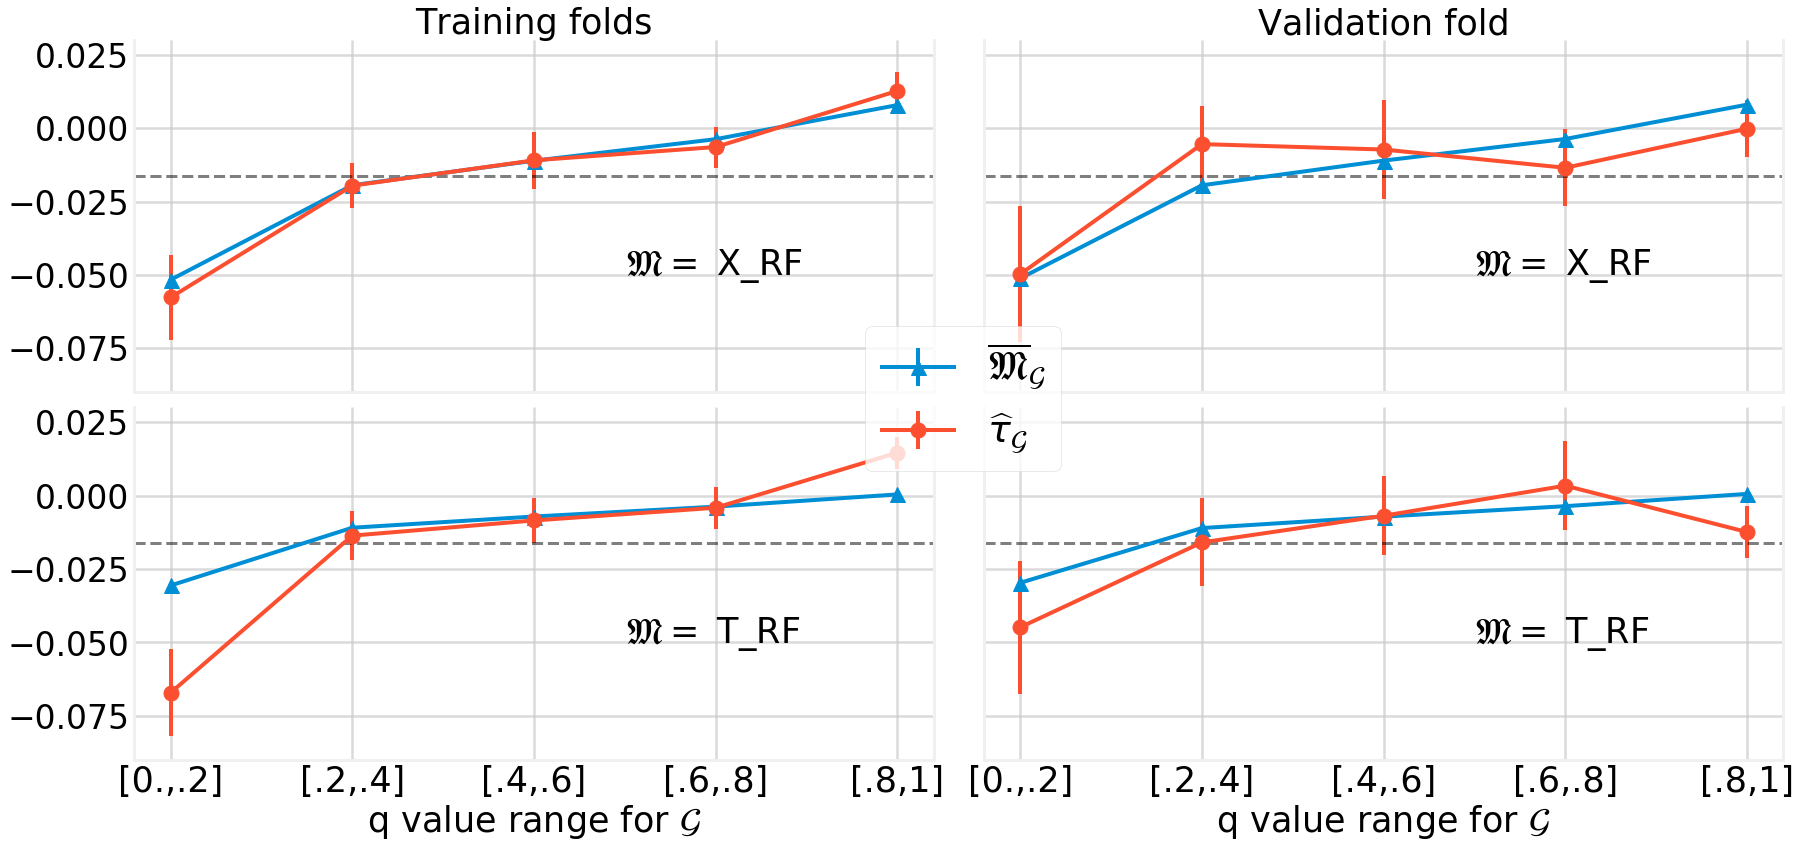

In [14]:
label_size = 35
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = 33
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size

xticks = ['[0.,.2]', '[.2,.4]', '[.4,.6]', '[.6,.8]', '[.8,1]']
fig, axes = plt.subplots(2, 2, sharey = True, sharex=True, figsize = [25, 12])
axes = axes.flatten()
for j, estimator in enumerate(['x_rf', 's_rf']):
    ax1, ax2 = axes[2*j], axes[2*j+1]
    for k, (lab, title, ax) in enumerate(zip(["train", "val"], 
                                             ["Training folds", "Validation fold"], 
                                             [ax1 ,ax2])):
        if j == 0:
            ax.set_title(title)
        # Plot model CATEs
        p1 = ax.errorbar(x = np.arange(0, n_bins), 
                    y = cal_plot_data[k][estimator]["model_CATEs"], 
                    yerr = cal_plot_data[k][estimator]["model_CATEs_std"],
                    marker= '^', markersize = 15, #color = "red",
                    linewidth = 4., 
                    label = r'$\overline{\mathfrak{M}}_{\mathcal {G}}$')
        # Plot Neyman CATEs
        p2 = ax.errorbar(x = np.arange(0, n_bins), 
                    y = cal_plot_data[k][estimator]["Neyman_CATEs"],
                    yerr = cal_plot_data[k][estimator]["Neyman_CATEs_std"],
                    marker = 'o', markersize = 15, #color = "blue",
                    linewidth = 4., 
                    label = r'$\widehat{\tau}_{\mathcal{G}}$')
        ax.text(x=2.5, y=-0.05, s= r'$\mathfrak{M}=$ ' + new_labels_dict[estimator], 
                fontsize=label_size)
        # Add line to indicate ATE
        ax.axhline(y = ATE, linestyle='--', color = 'k', linewidth = 3., alpha = 0.5)
        ax.set_ylim([-0.09, 0.03])
        # X labels and legend
        if j == 1:
            ax.set_xticks(np.arange(0, n_bins))
#             ax.set_xticklabels(cal_plot_data[k][estimator].index)
            ax.set_xticklabels(xticks)
            ax.set_xlabel(r"q value range for $\mathcal{G}$")
#         if j == 0:
#             if k == 0:
#                 ax.legend(fontsize = 45)
            
        ax.grid(True, alpha = 0.7)
#         ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
#         ax.spines['bottom'].set_visible(False)
# plt.suptitle("TC Events", y=1.01)
plt.tight_layout()
# Add legend
leg = fig.legend((p1, p2), (r'$\overline{\mathfrak{M}}_{\mathcal {G}}$', 
                            r'$\widehat{\tau}_{\mathcal{G}}$'), 'center right', 
                 bbox_to_anchor=(0.6, 0.52), fontsize=38,
                 frameon=True)

if savfig:
    plt.savefig(SAVE_PATH + f"{outcome_name}_x_rf_s_rf_calibration_plot.pdf",
                bbox_inches='tight')
# leg.remove()
# if savfig:
#     plt.savefig(SAVE_PATH + f"{outcome_name}_x_rf_s_rf_calibration_plot_no_leg.pdf"
#                 , bbox_inches='tight')
# plt.show()

### 2.2. CR2 generalization scatter plots

In [15]:
# Get data to make plot
cr2_5r_plot_data = {}
for estimator in selected_estimators:
    cr2_5r_plot_data[estimator] = \
            get_cr2_plot_data(fitted_libraries["pert_none"][estimator],
                              n_bins, n_bins_selected = n_bins,
                              dir_neg = dir_neg)

cr2_2r_plot_data = {}
for estimator in selected_estimators:
    cr2_2r_plot_data[estimator] = \
            get_cr2_plot_data(fitted_libraries["pert_none"][estimator], 
                              n_bins, n_bins_selected = 2, 
                              dir_neg = dir_neg)

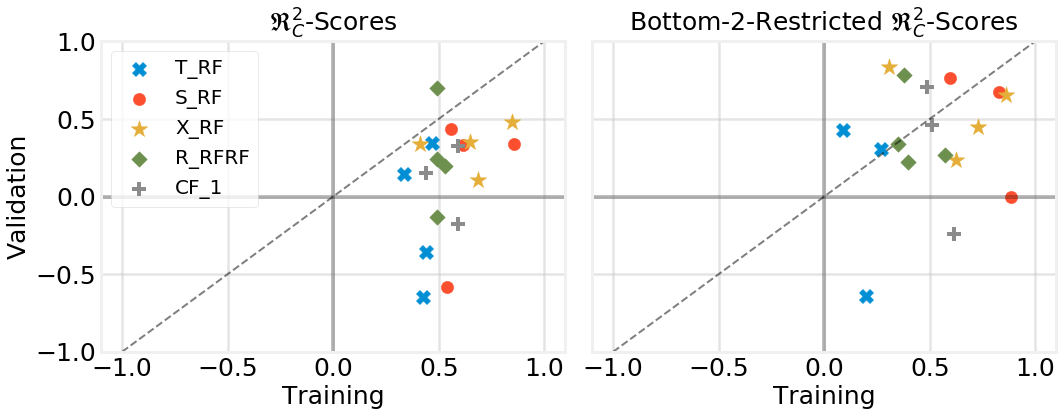

In [18]:
label_size = 25
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mss = ['X', 'o', '*', 'D', '+']
ms_size = [200, 150, 300, 120, 200]

f, (ax1, ax2) = plt.subplots(1, 2, sharey = True, sharex = True, 
                             figsize = [15, 6])

for i, estimator in enumerate(selected_estimators):
    ax1.scatter(cr2_5r_plot_data[estimator]["cr2_train"], 
                cr2_5r_plot_data[estimator]["cr2_val"], 
                label = new_labels_dict[estimator], marker = mss[i], 
                s=ms_size[i])
ax1.plot([-1, 1], [-1, 1], 'k--', alpha = 0.5, linewidth = 2.)
ax1.axhline(y = 0, color = 'k', alpha = .25)
ax1.axvline(x = 0, color = 'k', alpha = .25)
ax1.set_ylabel("Validation")
ax1.set_xlabel("Training")
ax1.set_title(r"$\mathfrak{R}_C^2$-Scores")
ax1.grid(True, alpha = 0.5)
ax1.legend(loc="upper left")

for i, estimator in enumerate(selected_estimators):
    ax2.scatter(cr2_2r_plot_data[estimator]["cr2_train"], 
                cr2_2r_plot_data[estimator]["cr2_val"], 
                label = estimator, marker = mss[i], s=ms_size[i])
ax2.plot([-1, 1], [-1, 1], 'k--', alpha = 0.5, linewidth = 2.)
ax2.axhline(y = 0, color = 'k', alpha = .25)
ax2.axvline(x = 0, color = 'k', alpha = .25)
ax2.set_xlabel("Training")
ax2.set_title(r"Bottom-2-Restricted $\mathfrak{R}_C^2$-Scores")
ax2.grid(True, alpha = 0.5)

plt.ylim([-1, 1])
plt.tight_layout()

savfig = False
if savfig:
    plt.savefig(SAVE_PATH + f"{outcome_name}_r2.pdf")
plt.show()

In [42]:
joblib.dump([cr2_5r_plot_data, cr2_2r_plot_data], f"data_files/{outcome_name}/{outcome_name}_rscores")

['data_files/GI/GI_rscores']

### 2.3. Aggregate R2 statistics

In [7]:
# Get data to make plot
all_estimators = list(fitted_libraries["pert_none"].keys())

cr2_plot_data = {}
for estimator in all_estimators:
    cr2_plot_data[estimator] = get_cr2_plot_data(fitted_libraries["pert_none"][estimator], 
                                                 n_bins)
    cr2_plot_data[estimator] = pd.concat([cr2_plot_data[estimator],
                            get_cr2_plot_data(fitted_libraries["pert_cv_0"][estimator], 
                                              n_bins)])
    cr2_plot_data[estimator] = pd.concat([cr2_plot_data[estimator],
                            get_cr2_plot_data(fitted_libraries["pert_cv_1"][estimator], 
                                              n_bins)])
    cr2_plot_data[estimator] = cr2_plot_data[estimator].reset_index() \
                                                       .drop(columns = ["index"])

for estimator in all_estimators:
    cr2_plot_data[estimator] = cr2_plot_data[estimator].reset_index() \
                                                       .drop(columns = ["index"])
all_cr2_scores_val = pd.concat(cr2_plot_data[estimator]["cr2_val"] 
                               for estimator in all_estimators)

all_cr2_scores_train = pd.concat(cr2_plot_data[estimator]["cr2_train"] 
                               for estimator in all_estimators)

Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.


In [20]:
all_estimators = np.array(all_estimators)
estimator_argsort = np.argsort([-cr2_plot_data[estimator]["cr2_val"].mean() 
                                for estimator in all_estimators])
all_estimators = all_estimators[estimator_argsort]

In [46]:
joblib.dump([all_cr2_scores_train, all_cr2_scores_val], f"data_files/{outcome_name}/{outcome_name}_rscores_hist")

['data_files/GI/GI_rscores_hist']

All-NaN slice encountered
All-NaN slice encountered


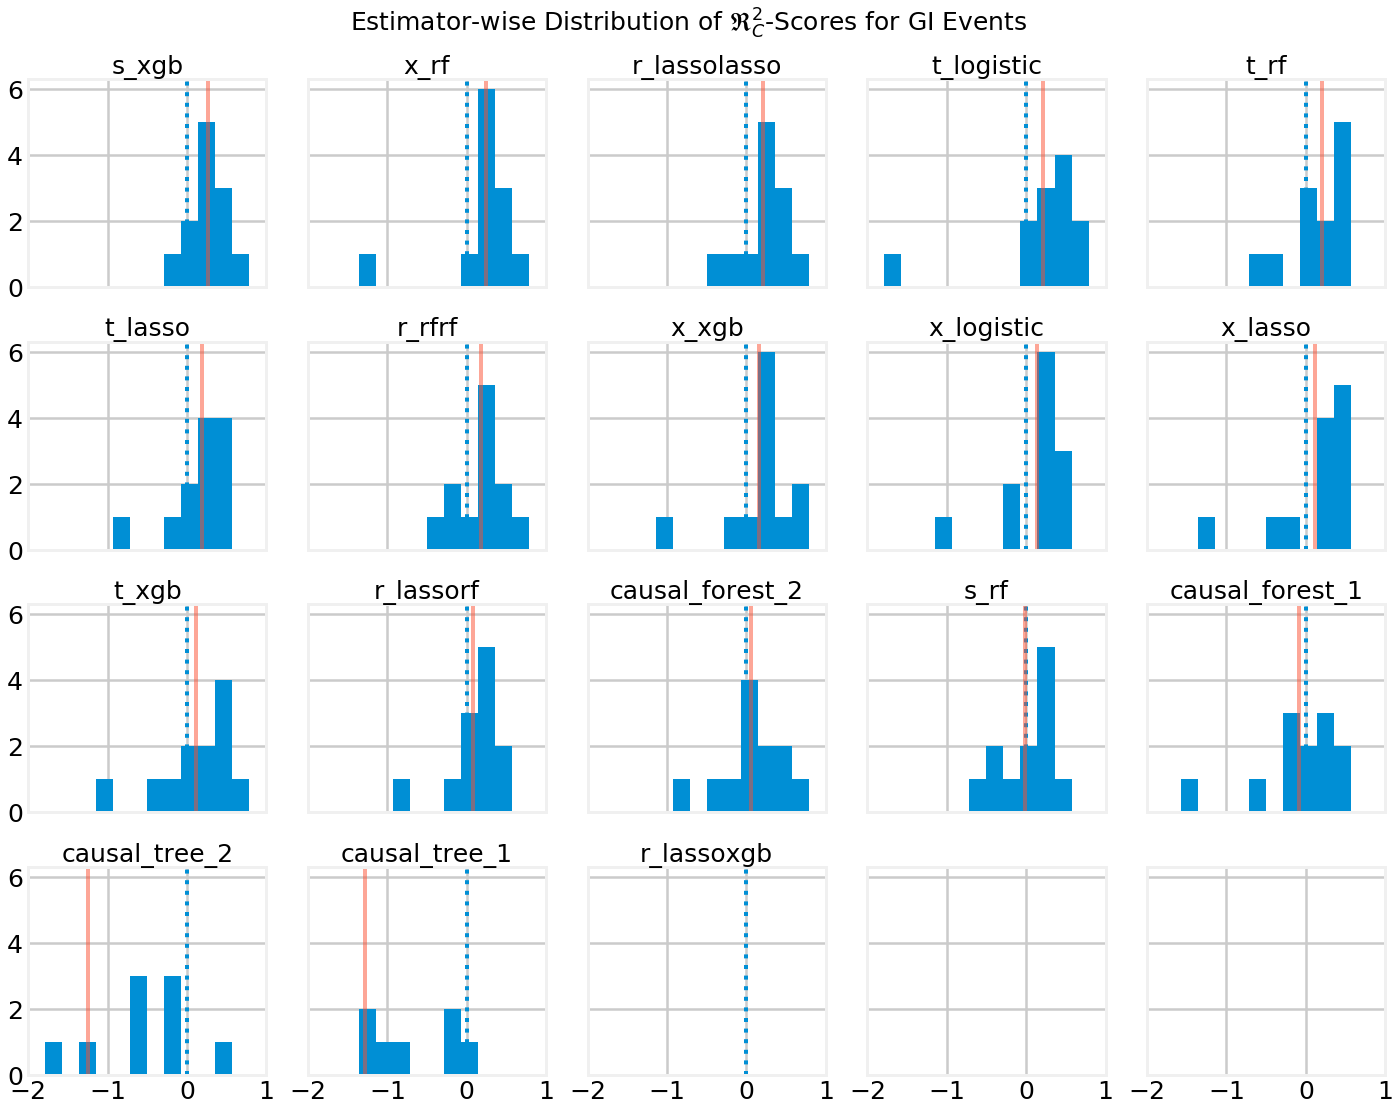

In [21]:
f, axes = plt.subplots(4, 5, figsize=[20, 15], sharex = True, sharey = True)
axes = axes.flatten()
for i, estimator in enumerate(all_estimators):
    ax = axes[i]
    ax.hist(cr2_plot_data[estimator]["cr2_val"], bins = np.linspace(-2,1,15))
    ax.axvline(0, alpha=1., linestyle=':')
    ax.axvline(cr2_plot_data[estimator]["cr2_val"].mean(), linestyle='-', 
               color=colors[1], alpha=0.5)
    ax.set_title(estimator)
    ax.set_xticks([-2, -1, 0, 1.])
    plt.xlim([-2, 1])
plt.tight_layout()
plt.suptitle(r"Estimator-wise Distribution of $\mathfrak{R}_C^2$-Scores for GI Events", y = 1.03)
savfig = False
if savfig:
    plt.savefig(SAVE_PATH + f"{outcome_name}_estimator_wise_r2.pdf")
plt.show()

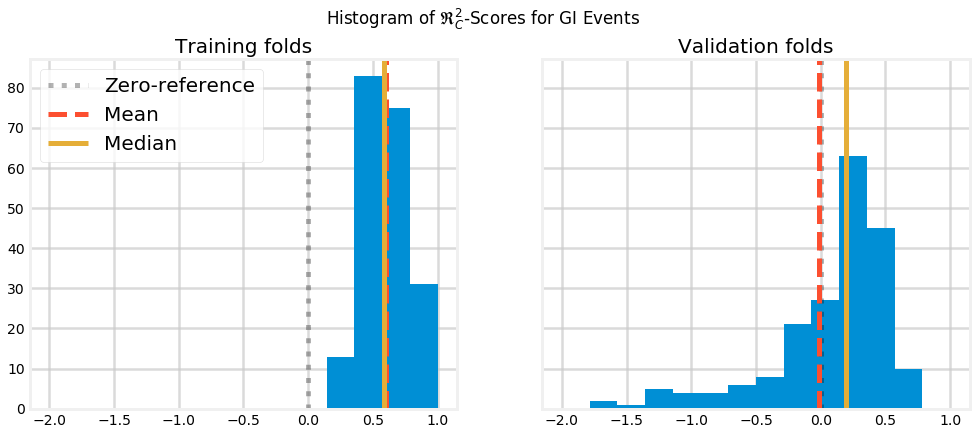

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey = True, sharex = True, figsize = [15, 6])

ax1.hist(all_cr2_scores_train, bins = np.linspace(-2,1,15))
ax1.axvline(0, alpha=.3, color='k', linestyle=':',linewidth=5.,
           label="Zero-reference")
ax1.axvline(all_cr2_scores_train.mean(), linestyle='--', color=colors[1], alpha=1,linewidth=5.,
            label="Mean")
ax1.axvline(all_cr2_scores_train.median(), linestyle='-', color=colors[2], alpha=1.,linewidth=5.,
            label="Median")
ax1.set_title("Training folds")
ax1.legend(fontsize=20)
ax1.grid(True, alpha = 0.7)

ax2.hist(all_cr2_scores_val, bins = np.linspace(-2,1,15))
ax2.axvline(0, alpha=.3, color='k', linestyle=':',linewidth=5.,
           label="O-reference")
ax2.axvline(all_cr2_scores_val.mean(), linestyle='--', color=colors[1], alpha=1,
            linewidth=5.,
           label="Mean")
ax2.axvline(all_cr2_scores_val.median(), linestyle='-', color=colors[2], alpha=2,
            linewidth=5.,
           label="Median")
ax2.set_title("Validation folds")
ax2.grid(True, alpha = 0.7)
plt.suptitle(r"Histogram of $\mathfrak{R}_C^2$-Scores for GI Events",  y=1.0)

savfig = False
if savfig:
    plt.savefig(SAVE_PATH + f"{outcome_name}_distribution_r2.pdf")
plt.show()

In [ ]:
all_cr2_scores_train

Takeaways: Poor prediction performance
1. Calibration plots show that the validation set is too small to accurately gauge prediction accuracy of CATE estimators.  
2. $C-R^2$ scatter plots show further evidence of overfitting. (training scores are systematically higher than validation scores).   
3. $C-R^2$ histograms show that across all estimators and 12 different training-validation data splits, the overwhelming majority of scores is less than 0.5,  
i.e. only reduces l1-variability by 50% from the ATE constant predictor baseline.

## 3. Monotonicity

- Top estimators are computed in 04a
- Refer to `06_plots` for the monotonicity boxplot

In [5]:
top_estimator_names = joblib.load(f"data_files/{outcome_name}/{outcome_name}_top_estimator_names")
dropped_estimators = ["r_lassoxgb"]
print(top_estimator_names)

['t_lasso', 'x_rf', 't_rf', 'x_xgb', 'x_lasso', 'x_logistic']


### 3.1. Monotinicity with respect to 5 bins  

In [6]:
monotonicity_df = get_monotonicity_results(fitted_libraries, top_estimator_names, 
                                           n_bins = 5, dir_neg = dir_neg, 
                                           dropped_estimators = dropped_estimators)

Mean of empty slice.
invalid value encountered in double_scalars
invalid value encountered in greater


In [7]:
monotonicity_df.round(2)

,"[0.0,0.2] vs [0.2, 0.4]","[0.2,0.4] vs [0.4, 0.6]","[0.4,0.6] vs [0.6, 0.8]","[0.6,0.8] vs [0.8, 1.0]",first_bin_is_min
s_rf,0.83,0.58,0.67,0.42,0.75
s_xgb,1.00,0.67,0.58,0.58,0.92
t_lasso,1.00,0.42,0.50,0.58,0.92
t_logistic,1.00,0.67,0.83,0.25,1.00
t_rf,0.92,0.75,0.50,0.33,0.83
t_xgb,0.92,0.42,0.67,0.17,0.83
x_lasso,1.00,0.50,0.58,0.67,1.00
x_logistic,1.00,0.33,0.50,0.75,0.92
x_rf,1.00,0.42,0.42,0.67,1.00
x_xgb,0.92,0.33,0.50,0.83,0.83


Remark: Top estimators determined using the methodology in notebook 04a.

In [53]:
joblib.dump(monotonicity_df, f"data_files/{outcome_name}/{outcome_name}_monotonicity_df")

['data_files/GI/GI_monotonicity_df']

In [8]:
# Run this cell to get latex code for the table
#print(monotonicity_df.sort_values("first_bin_is_min", ascending=False).round(2).to_latex())

### 3.2. Comparing quantile-based top subgroup with its complement

In [6]:
new_monotonicity_df = get_monotonicity_results(fitted_libraries, top_estimator_names = top_estimator_names,
                                               q_values = [0.1, 0.2, 0.3, 0.4, 0.5], dir_neg = True, 
                                               dropped_estimators = dropped_estimators)

In [7]:
new_monotonicity_df.round(2)

,"[0.0,0.1] vs [0.1, 1.]","[0.0,0.2] vs [0.2, 1.]","[0.0,0.3] vs [0.3, 1.]","[0.0,0.4] vs [0.4, 1.]","[0.0,0.5] vs [0.5, 1.]"
s_rf,1.00,0.92,0.83,0.92,0.83
s_xgb,0.92,1.00,1.00,1.00,0.92
t_lasso,0.92,1.00,1.00,1.00,1.00
t_logistic,1.00,1.00,1.00,1.00,1.00
t_rf,0.92,0.92,1.00,0.92,1.00
t_xgb,0.92,1.00,0.92,1.00,0.92
x_lasso,0.92,1.00,1.00,1.00,1.00
x_logistic,0.92,1.00,1.00,1.00,1.00
x_rf,0.92,1.00,1.00,1.00,0.92
x_xgb,0.92,1.00,1.00,1.00,0.92


In [8]:
joblib.dump(new_monotonicity_df, f"data_files/{outcome_name}/{outcome_name}_new_monotonicity_df")

['data_files/GI/GI_new_monotonicity_df']

## 4. Stability of CATE estimators

### 4.1. Stability of quantile-based top subgroup

In this section, we examine the stability of the quantile-based subgroups by generalizing the notion of overlap.  
We consider the quantile-based top subgroup for q=0.2, and compute what percentage of its members are contained  
in the quantile-based top subgroup for other values of q, when the two subgroups are obtained from CATE estimators  
trained on different data splits.

In [9]:
library_names = ["pert_none", "pert_cv_0", "pert_cv_1"]
library = {}
for estimator_name in fitted_libraries["pert_none"].keys():
    list_of_estimators = []
    for library_name in library_names:
        list_of_estimators.append(fitted_libraries[library_name][estimator_name])
    library[estimator_name] = combine_estimator_versions(list_of_estimators)
stability_scores = {}
q0 = 0.2
q_values_v2 = [0.2, 0.3, 0.4, 0.5]
for estimator_name, estimator in library.items():
    stability_scores[estimator_name] = get_top_subgroup_stability(estimator, q0, q_values_v2, dir_neg).round(2)

In [11]:
same_q_scores = []
diff_q_scores = []
for scores in stability_scores.values():
    same_q_scores.append(scores.loc[0.2,"mean coverage"])
    diff_q_scores.append(scores.loc[0.3,"mean coverage"])
scores_df = pd.DataFrame({"estimator" : list(stability_scores.keys()),
                          "0.2" : same_q_scores,
                          "0.3" : diff_q_scores})
scores_df = scores_df.set_index("estimator")
scores_df.drop(index = ["r_lassoxgb"], inplace = True)

In [13]:
scores_df

,0.2,0.3
estimator,,
s_rf,0.69,0.81
s_xgb,0.75,0.83
t_lasso,0.77,0.92
t_logistic,0.79,0.92
t_rf,0.73,0.87
t_xgb,0.71,0.87
x_lasso,0.75,0.90
x_logistic,0.75,0.90
x_rf,0.77,0.91


### 4.2. Overlaps of quantile-based subgroups

In [21]:
all_overlaps = get_overlap_values(fitted_libraries, 0, 0.2, compare_across = "all", 
                                  dropped_estimators = "r_lassoxgb")

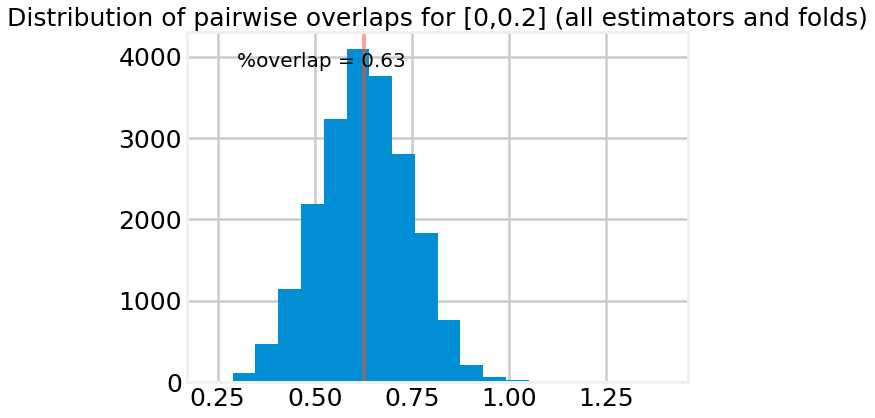

In [22]:
plt.hist(all_overlaps, bins = 20, zorder = 1)
plt.title("Distribution of pairwise overlaps for [0,0.2] (all estimators and folds)")
mean_overlap = all_overlaps.mean()
plt.axvline(x = mean_overlap, linestyle='-', color=colors[1], alpha=0.5, zorder = 2)
ax = plt.gca()
plt.annotate("%overlap = {:.2f}".format(mean_overlap),
             xy = (0.1, 0.9), xycoords = ax.transAxes,
             fontsize = 20)
plt.show()

In [23]:
estimator_overlaps = get_overlap_values(fitted_libraries, 0, 0.2, compare_across = "estimators",
                                        fold = 0, dropped_estimators = "r_lassoxgb")

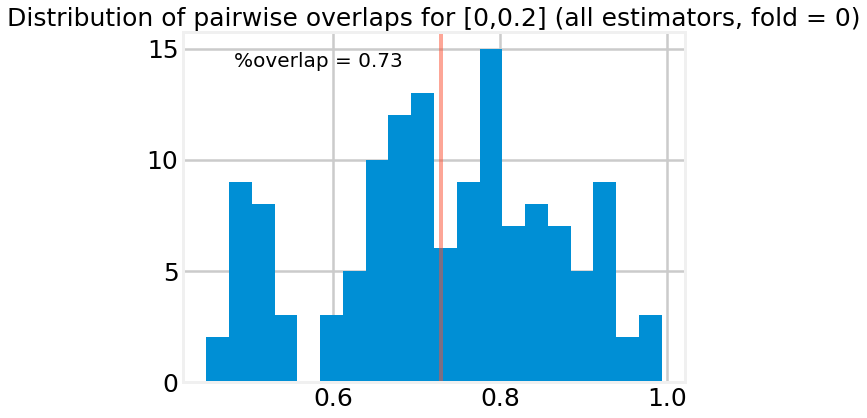

In [24]:
plt.hist(estimator_overlaps, bins = 20, zorder = 1)
plt.title("Distribution of pairwise overlaps for [0,0.2] (all estimators, fold = 0)")
mean_overlap = estimator_overlaps.mean()
plt.axvline(x = mean_overlap, linestyle='-', color=colors[1], alpha=0.5, zorder = 2)
ax = plt.gca()
plt.annotate("%overlap = {:.2f}".format(mean_overlap),
             xy = (0.1, 0.9), xycoords = ax.transAxes,
             fontsize = 20)
plt.show()

In [25]:
# Get data to make plot
selected_estimators = list(fitted_libraries["pert_none"].keys())
selected_estimators.remove("r_lassoxgb")
overlap_plot_data = {}
for estimator in selected_estimators:
    overlap_plot_data[estimator] = get_overlap_values(fitted_libraries, 0, 0.2,
                                                      compare_across = "folds",
                                                      estimator = estimator)
# Order the estimators in decreasing order w.r.t. mean overlap
selected_estimators = np.array(selected_estimators)
estimator_argsort = np.argsort([-overlap_plot_data[estimator].mean() for estimator in selected_estimators])
selected_estimators = selected_estimators[estimator_argsort]

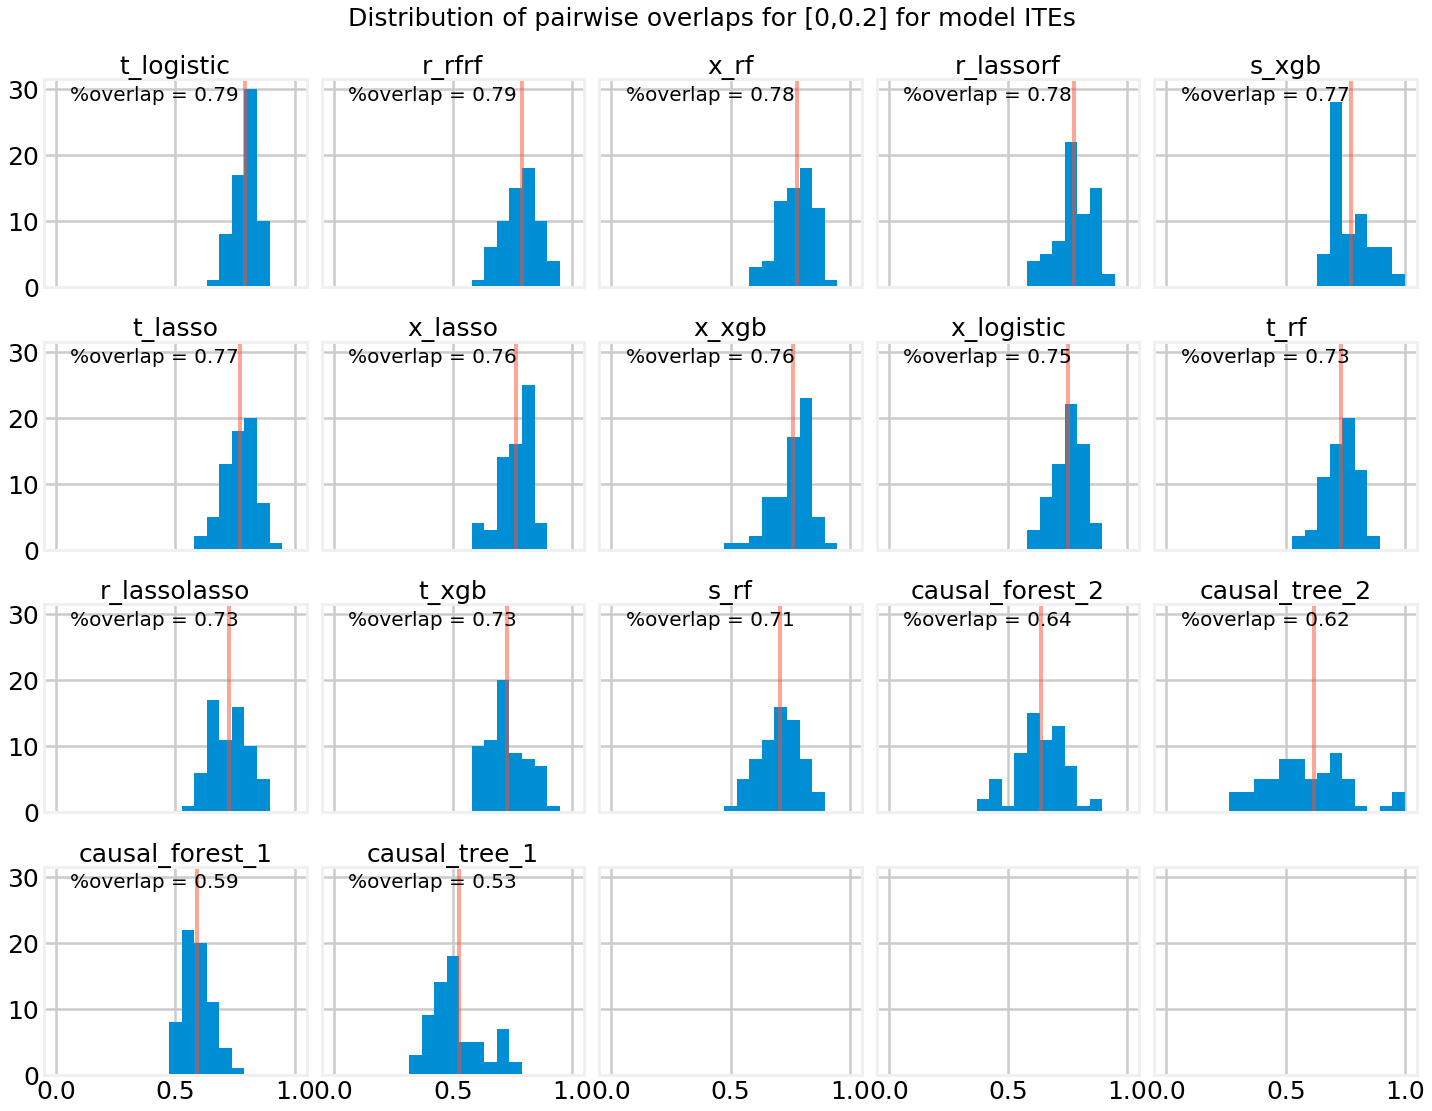

In [26]:
f, axes = plt.subplots(4, 5, figsize=[20, 15], sharex = True, sharey = True)
axes = axes.flatten()
for i, estimator in enumerate(selected_estimators):
    ax = axes[i]
    ax.hist(overlap_plot_data[estimator], bins = np.linspace(0, 1, 20))
    mean_overlap = overlap_plot_data[estimator].mean()
    ax.axvline(mean_overlap, linestyle='-', color=colors[1], alpha=0.5)
    ax.annotate("%overlap = {:.2f}".format(mean_overlap),
                xy = (.1, .9), xycoords = ax.transAxes,
                fontsize = 20)
    ax.set_title(estimator)
#    ax.set_xticks([-2, -1, 0, 1.])
#    plt.xlim([-2, 1])
plt.tight_layout()
plt.suptitle("Distribution of pairwise overlaps for [0,0.2] for model ITEs", y = 1.03)
plt.show()

In [27]:
# Get data to make plot
selected_estimators = list(fitted_libraries["pert_none"].keys())
selected_estimators.remove("r_lassoxgb")
overlap_plot_data = {}
for estimator in selected_estimators:
    overlap_plot_data[estimator] = get_overlap_values(fitted_libraries, 0.2, 0.4,
                                                      compare_across = "folds",
                                                      estimator = estimator)
# Order the estimators in decreasing order w.r.t. mean overlap
selected_estimators = np.array(selected_estimators)
estimator_argsort = np.argsort([-overlap_plot_data[estimator].mean() for estimator in selected_estimators])
selected_estimators = selected_estimators[estimator_argsort]

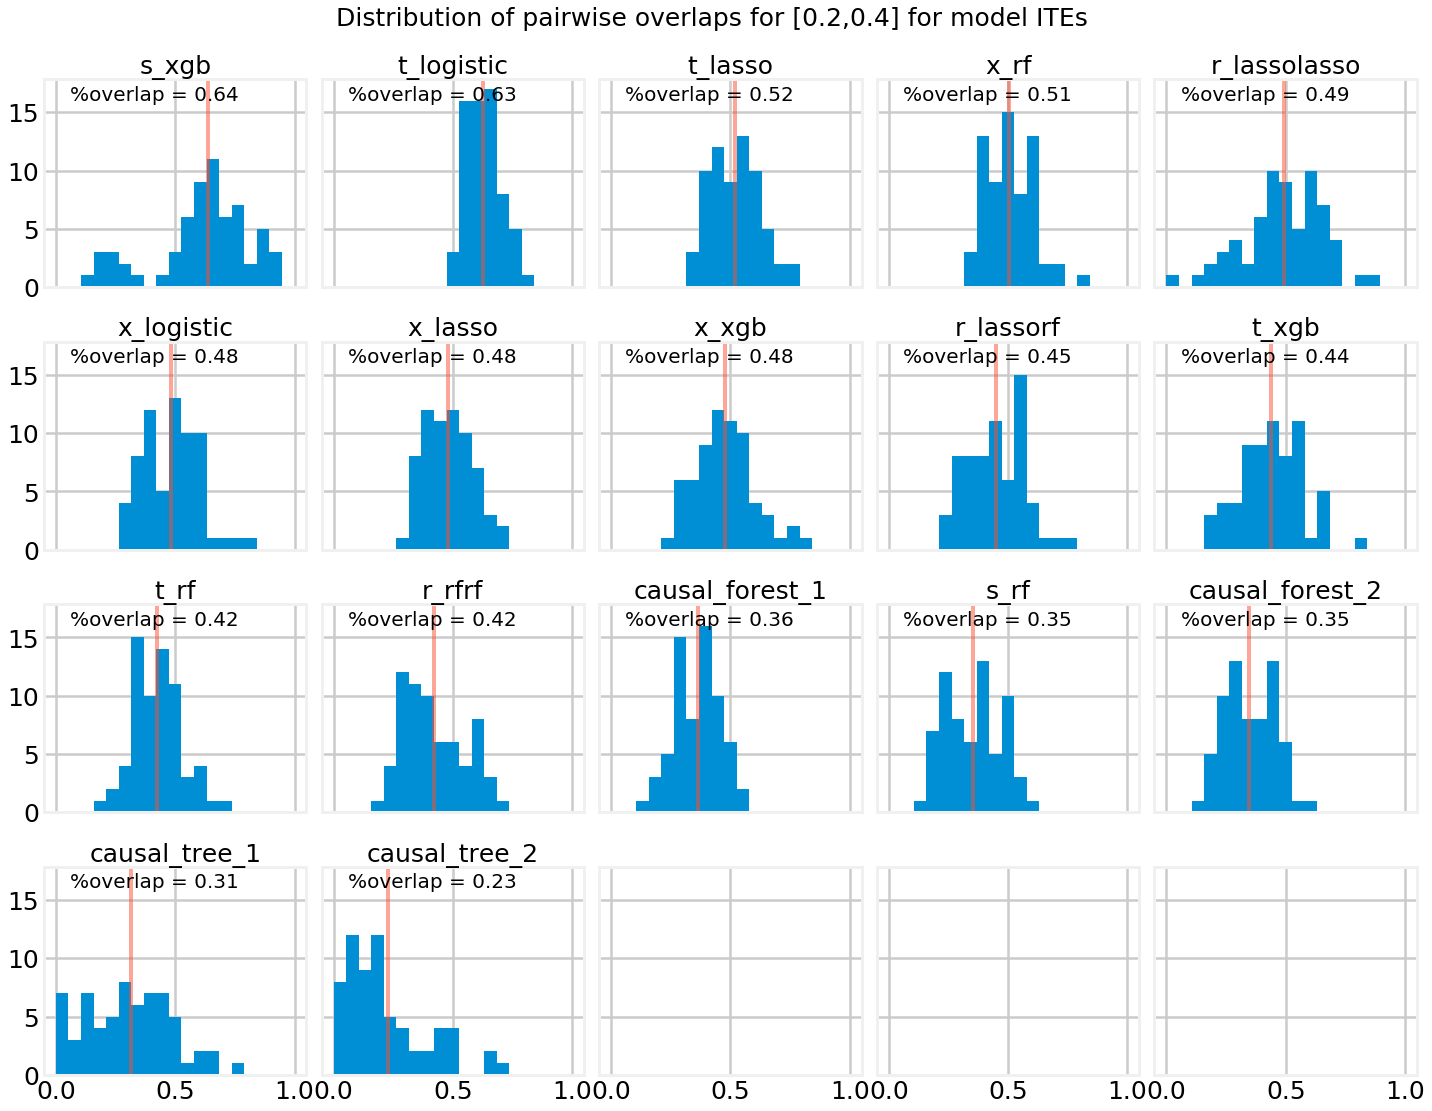

In [28]:
f, axes = plt.subplots(4, 5, figsize = [20, 15], sharex = True, sharey = True)
axes = axes.flatten()
for i, estimator in enumerate(selected_estimators):
    ax = axes[i]
    ax.hist(overlap_plot_data[estimator], bins = np.linspace(0, 1, 20))
    mean_overlap = overlap_plot_data[estimator].mean()
    ax.axvline(mean_overlap, linestyle='-', color=colors[1], alpha = 0.5)
    ax.annotate("%overlap = {:.2f}".format(mean_overlap),
                xy = (.1, .9), xycoords = ax.transAxes,
                fontsize = 20)
    ax.set_title(estimator)
#    ax.set_xticks([-2, -1, 0, 1.])
#    plt.xlim([-2, 1])
plt.tight_layout()
plt.suptitle("Distribution of pairwise overlaps for [0.2,0.4] for model ITEs", y = 1.03)
plt.show()

In [29]:
# Get data to make plot
selected_estimators = list(fitted_libraries["pert_none"].keys())
selected_estimators.remove("r_lassoxgb")
overlap_plot_data = {}
for estimator in selected_estimators:
    overlap_plot_data[estimator] = get_overlap_values(fitted_libraries, 0.8, 1,
                                                      compare_across = "folds",
                                                      estimator = estimator)
# Order the estimators in decreasing order w.r.t. mean overlap
selected_estimators = np.array(selected_estimators)
estimator_argsort = np.argsort([-overlap_plot_data[estimator].mean() 
                                for estimator in selected_estimators])
selected_estimators = selected_estimators[estimator_argsort]

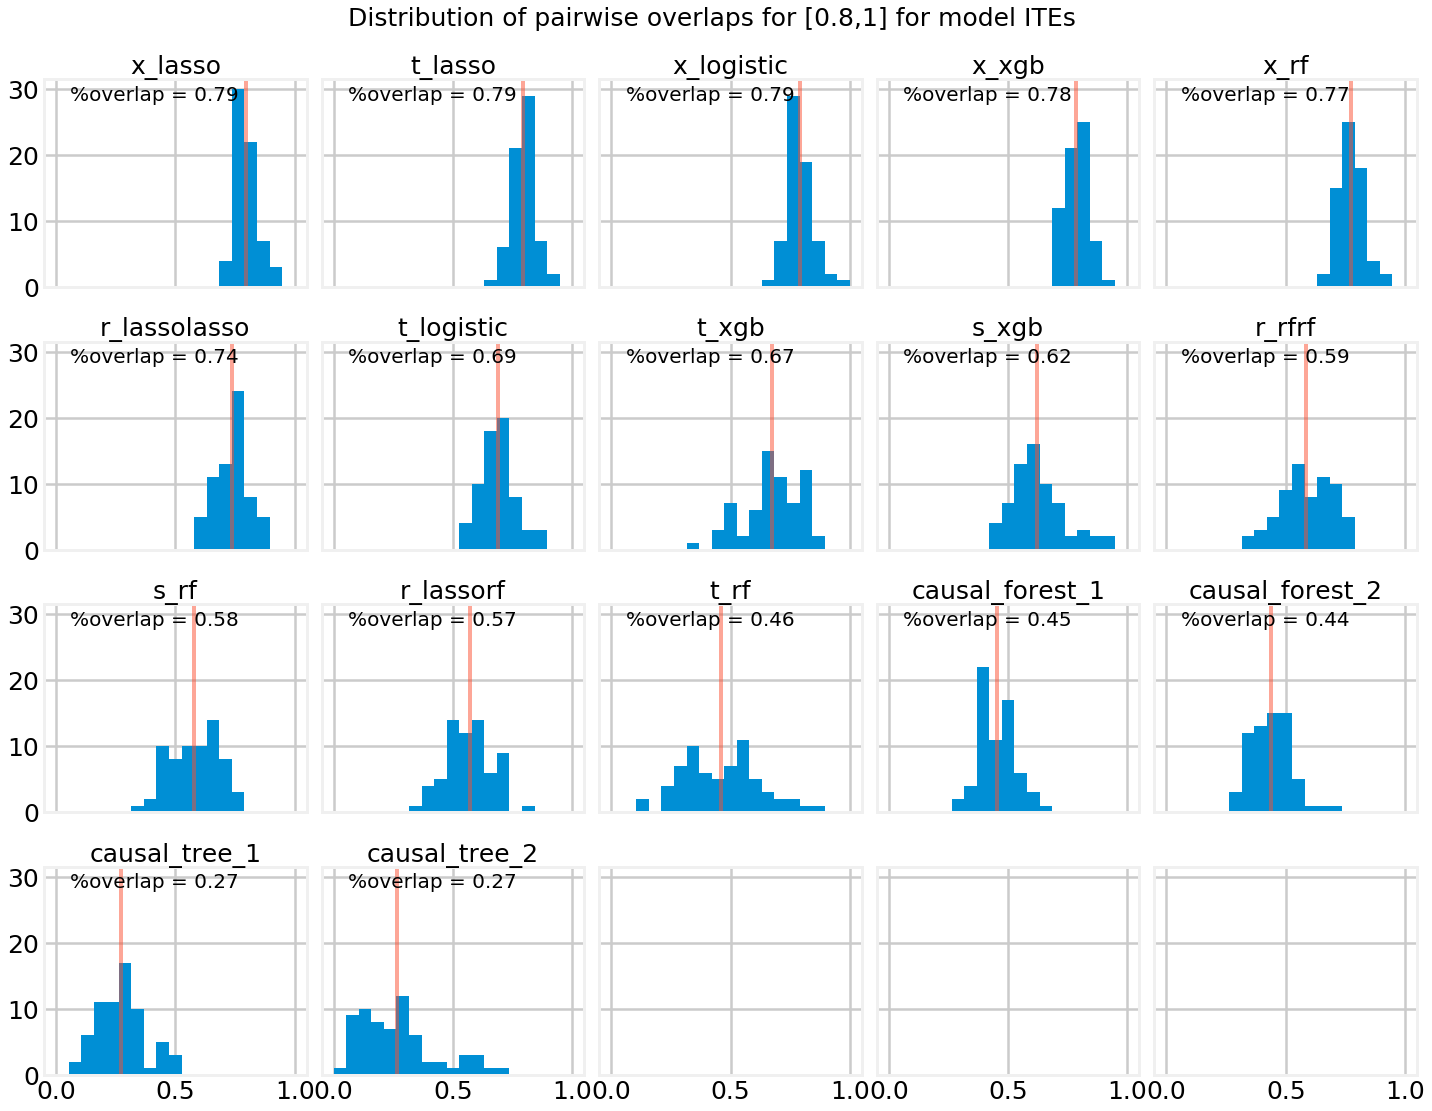

In [30]:
f, axes = plt.subplots(4, 5, figsize=[20, 15], sharex = True, sharey = True)
axes = axes.flatten()
for i, estimator in enumerate(selected_estimators):
    ax = axes[i]
    ax.hist(overlap_plot_data[estimator], bins = np.linspace(0, 1, 20))
    mean_overlap = overlap_plot_data[estimator].mean()
    ax.axvline(mean_overlap, linestyle='-', color=colors[1], alpha = 0.5)
    ax.annotate("%overlap = {:.2f}".format(mean_overlap),
                xy = (.1, .9), xycoords = ax.transAxes,
                fontsize = 20)
    ax.set_title(estimator)
#    ax.set_xticks([-2, -1, 0, 1.])
#    plt.xlim([-2, 1])
plt.tight_layout()
plt.suptitle("Distribution of pairwise overlaps for [0.8,1] for model ITEs", y = 1.03)
plt.show()

### 4.3. Aggregate correlation statistics

In [31]:
all_correlations = get_r_values(fitted_libraries, compare_across = "all", 
                                dropped_estimators = "r_lassoxgb")
#all_correlations = all_correlations[~np.isnan(all_correlations)] In case of nan

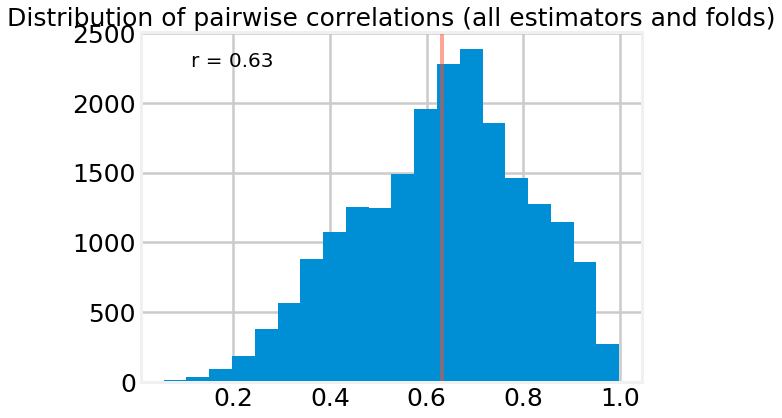

In [32]:
plt.hist(all_correlations, bins = 20, zorder = 1)
plt.title("Distribution of pairwise correlations (all estimators and folds)")
mean_r = all_correlations.mean()
plt.axvline(x = mean_r, linestyle='-', color=colors[1], alpha=0.5, zorder = 2)
ax = plt.gca()
plt.annotate("r = {:.2f}".format(mean_r),
             xy = (0.1, 0.9), xycoords = ax.transAxes,
             fontsize = 20)
plt.show()

### 4.4. Pairwise correlation for a single estimator when trained on different splits

In [17]:
marker_size = 20
alpha = 0.3

def make_model_CATE_pairplot(estimator, estimator_name = None):
    model_CATEs_df = pd.DataFrame({})
    for fold_no, result in estimator.results.items():
        model_CATEs_df[fold_no] = result.tau
    def corrfunc(x, y, **kwargs):
        r, _ = stats.pearsonr(x, y)
        ax = plt.gca()
        ax.annotate("r = {:.2f}".format(r),
                    xy = (.1, .9), xycoords = ax.transAxes,
                    fontsize = 20)
    g = sns.pairplot(model_CATEs_df, kind = "scatter", plot_kws = {"s" : marker_size,
                                                                   "alpha" : alpha})
    g = g.map_upper(corrfunc)
    g.fig.set_size_inches(15,15)
    title_string = "Pair plot for ITEs predicted by estimator when trained on 4 different folds"
    if estimator_name is not None:
        title_string += f": {estimator_name}"
    plt.suptitle(title_string, y = 1.03)
    plt.show()

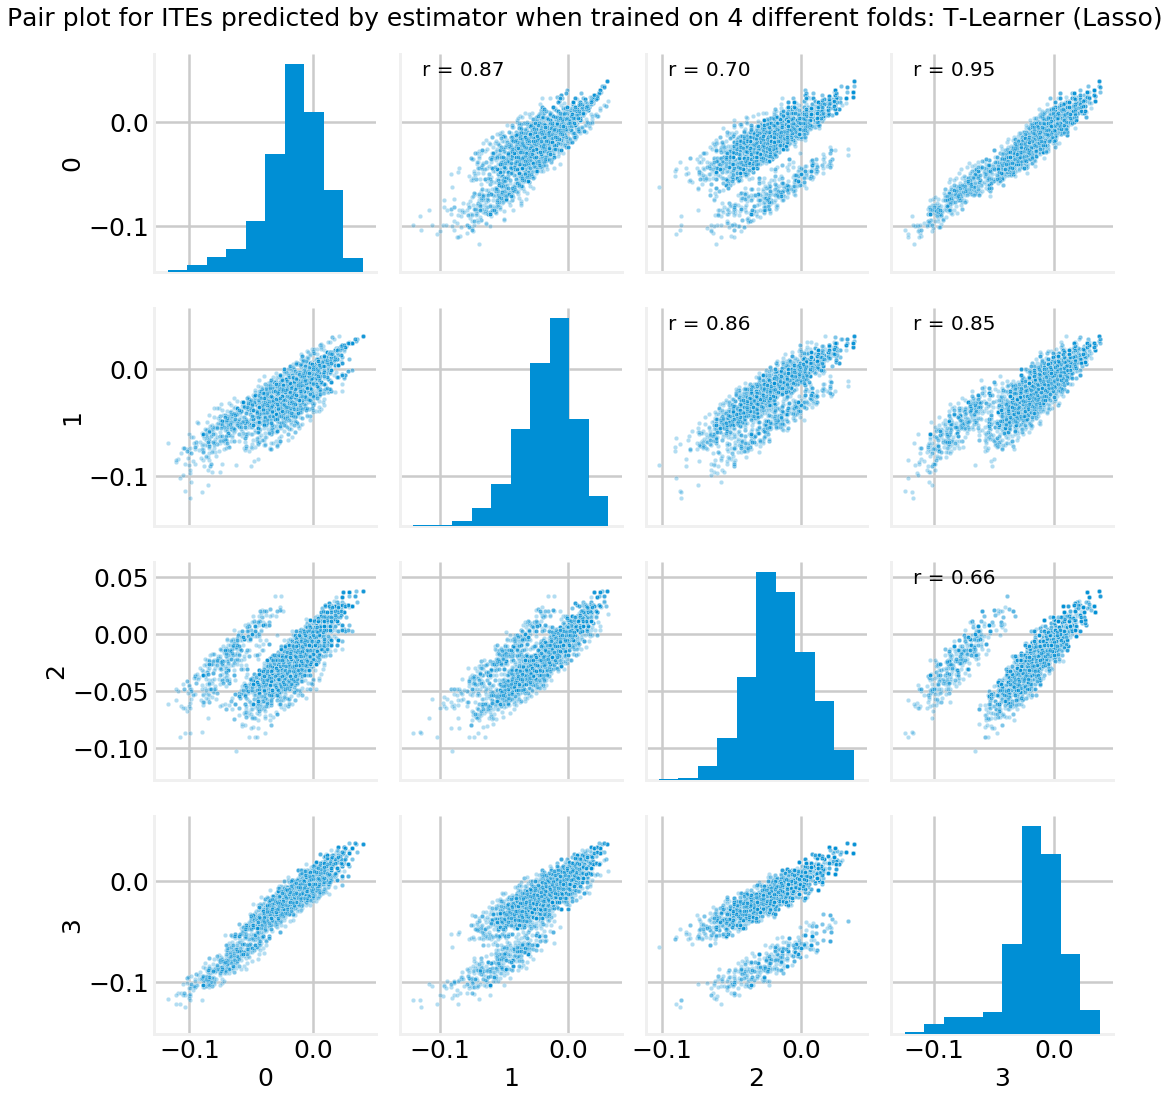

In [18]:
make_model_CATE_pairplot(fitted_libraries["pert_none"]["t_lasso"], "T-Learner (Lasso)")

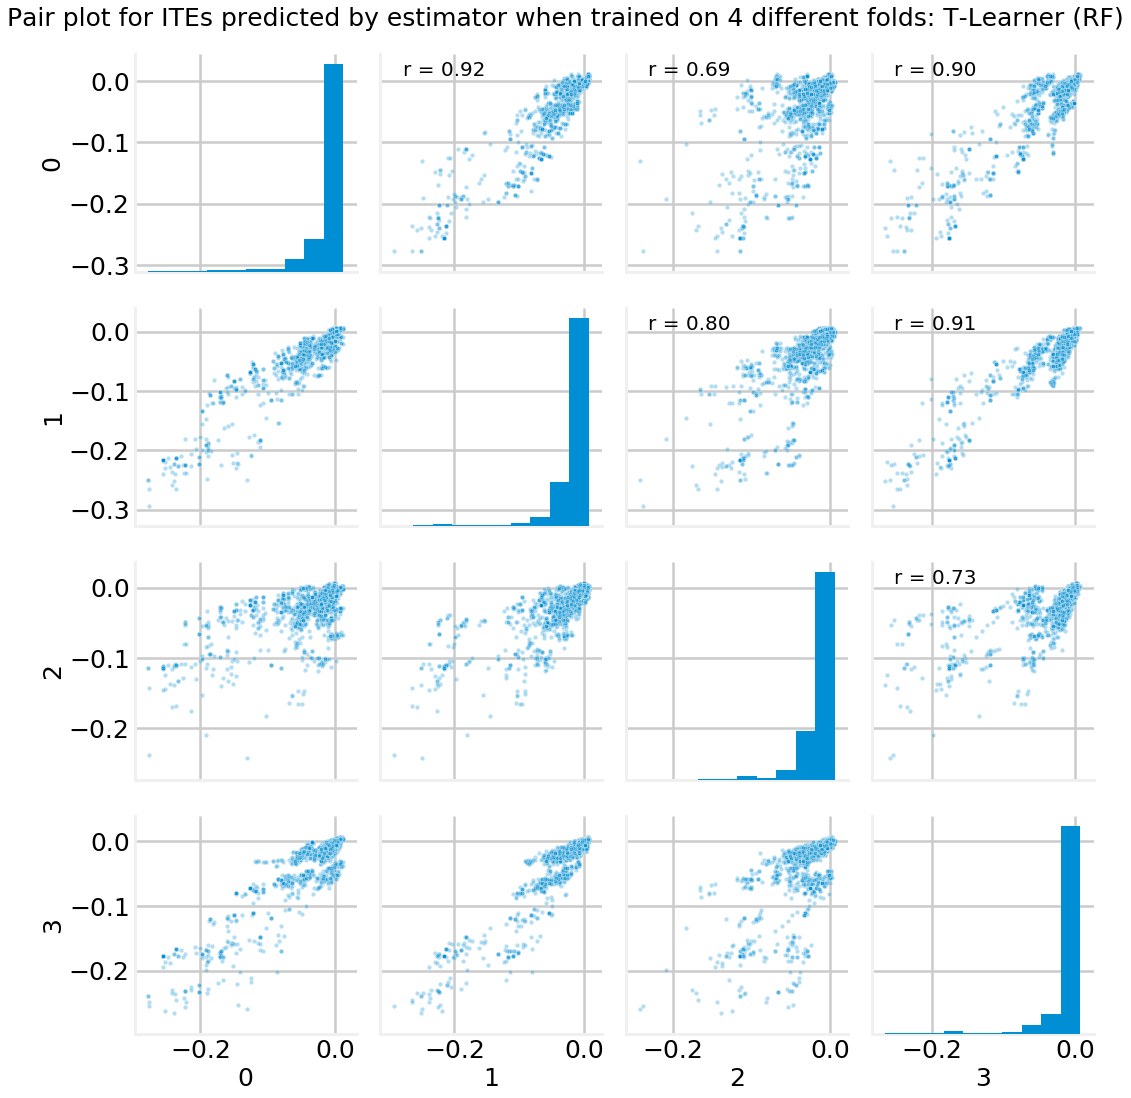

In [19]:
make_model_CATE_pairplot(fitted_libraries["pert_none"]["t_rf"], "T-Learner (RF)")

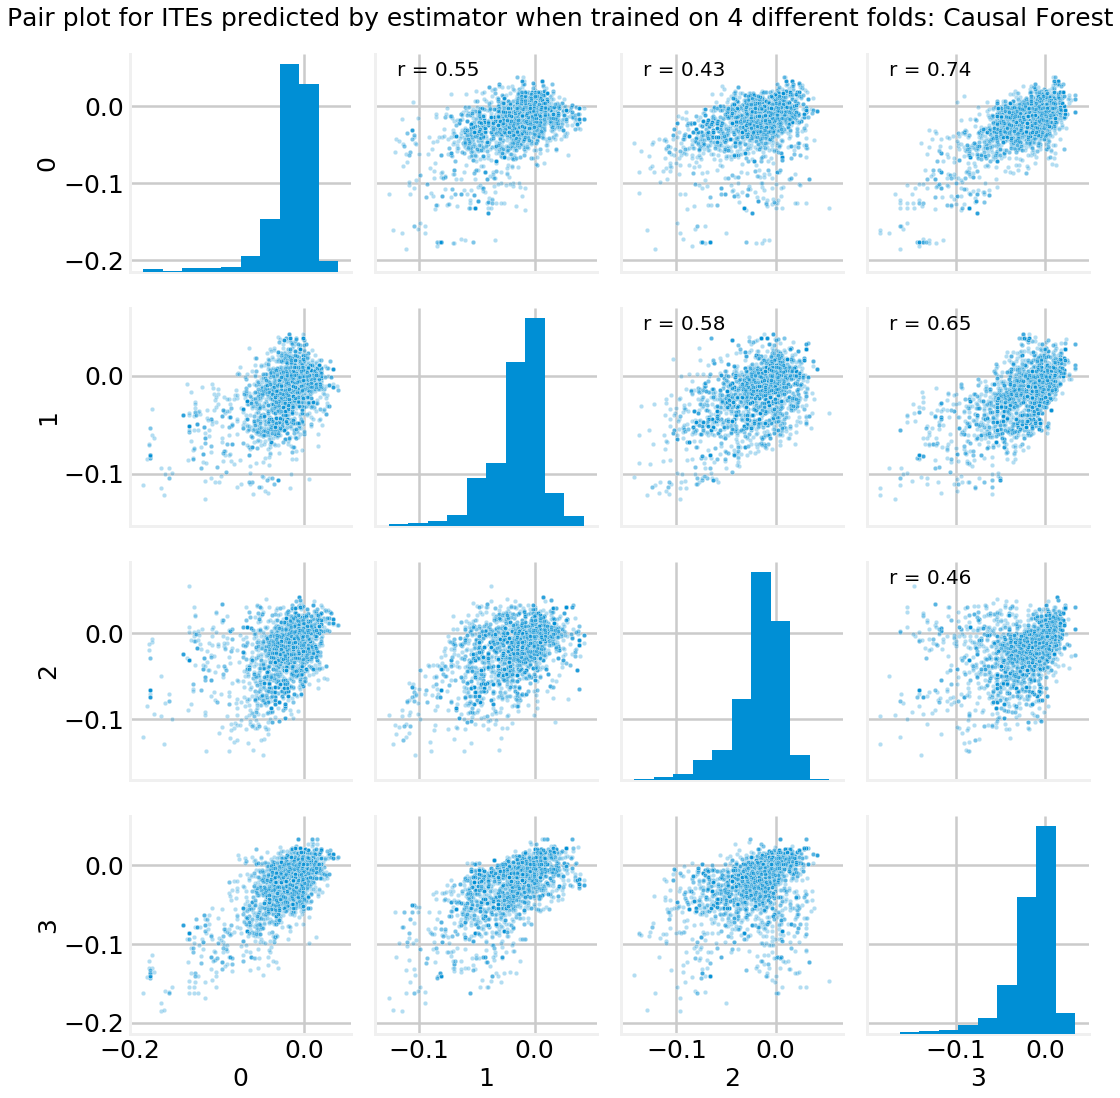

In [20]:
make_model_CATE_pairplot(fitted_libraries["pert_none"]["causal_forest_1"], "Causal Forest")

In [104]:
### OTHER WAYS TO PLOT IT
# plt.figure(figsize=[10, 6])
# plt.plot(df1["max"].values, marker='D', label='Difference')
# plt.plot(df2["max"].values, linestyle='--', marker='o', label='Logistic')
# plt.xticks(np.arange(len(df1)), ticks, rotation=90)
# plt.grid(False, axis='x')
# plt.title("Importance Scores")
# plt.show()

# plt.figure(figsize=[10, 6])
# plt.bar(x=np.arange(0, 2*len(df1), 2), height=df1["max"].values,label='Difference', width=0.6)
# plt.bar(x=np.arange(0, 2*len(df1), 2)+0.6,height=df2["max"].values, label='Logistic', width=0.6)
# plt.xticks(np.arange(0, 2*len(df1), 2)+0.3, ticks, rotation=90)
# plt.grid(False, axis='x')
# plt.legend()
# plt.title("Importance Scores")
# plt.show()

# plt.figure(figsize=[10, 6])
# plt.barh(y=np.arange(0, 3*len(df1), 3)[::-1], width=df1["max"].values,label='Difference', height=1)
# plt.barh(y=np.arange(0, 3*len(df1), 3)[::-1]+1,width=df2["max"].values, label='Logistic', height=1)
# plt.yticks(np.arange(0, 3*len(df1), 3)[::-1]+0.3, ticks)
# plt.grid(False, axis='y')
# plt.legend()
# plt.title("Importance Scores")
# plt.show()